In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [2]:
# utils
# do down sampling, w, h is the original picture width and height. 
# x, y is sample factor,  eg. yuv420, x = 2, y = 0
def downsample(data, w, h, x, y):
    ysize =  w * h
    # this is not a universal approach
    xstep = (int)(4 / x)
    ystep = 1
    if y == 0:
        ystep = 2
    uvsize = (int)(ysize / xstep / ystep)
    sample = np.zeros(uvsize).astype('float')
    for i in range(0, w, xstep):
        for j in range(0, h, ystep):
            pixelcount = 0
            pixel = 0.0
            for dx in range(xstep):
                for dy in range(ystep):
                    pixelcount = pixelcount + 1
                    pixel = pixel + data[(j+dy)*w + i + dx]
            sample[(int)((j/ystep)*(w/xstep) + i/xstep)] = pixel / pixelcount
    return sample

def upsample(sample, sw, sh, x, y):
    uvsize = sw * sh
    xstep = (int)(4 / x)
    ystep = 1
    if y == 0:
        ystep = 2
    ysize = uvsize * xstep * ystep
    w = sw * xstep
    h = sh * ystep
    data = np.zeros(ysize).astype('float')
    for i in range(sw):
        for j in range(sh):
            for dx in range(xstep):
                for dy in range(ystep):
                    data[(j*ystep+dy)*w+(i*xstep+dx)] = sample[j*sw+i]
    return data

def normalize255(rgb):
    (h, w, d) = rgb.shape
    for i in range(d):
        maxv = np.max(rgb[:,:,i])
        minv = np.min(rgb[:,:,i])
        distance = maxv - minv
        for x in range(w):
            for y in range(h):
                rgb[y, x, i] = rgb[y, x, i] * 255.0 / distance
        return rgb
    
def diff(rgb1, rgb2):
    (h1, w1, d1) = rgb1.shape
    (h2, w2, d2) = rgb2.shape
    if h1 != h2 or w1 != w2 or d1 != d2:
        print("dimension of the two images is not consistent")
        return
    diff_image = np.zeros((h1, w1, d1)).astype('uint8')
    for d in range(d1):
        for x in range(w1):
            for y in range(h1):
                diff_image[y,x,d] = np.abs(int(rgb1[y,x,d]) - int(rgb2[y,x,d]))
    diff_fig, diff_plt = plt.subplots(1, 1)
    diff_plt.set_title('Diff'); diff_plt.imshow(diff_image);

def describeYUV(y, u, v, name):
    (yh, yw) = y.shape
    (uh, uw) = u.shape
    (vh, vw) = v.shape
    print("%s image: Y (%dx%d), U (%dx%d), V (%dx%d), size %d bytes" % (name, yw, yh, uw, uh, vw, vh, yw*yh+uw*uh+vw*vh))

In [3]:
# here, all yuv formats are orgnized as planar format, which means it has three planes
# each plane stores y, u, v separately. aka. I444, I422, I420, etc.
# https://wiki.videolan.org/YUV#YUV_4:4:4

# https://www.red.com/red-101/video-chroma-subsampling

# yuv444 does not do chroma subsampling, just convert pixel RGV value to YUV (luma + chroma).
# here use BT.601 coefficients
def rgb8882yuv444(img):
    (h, w, d) = img.shape
    yuvsize = h * w * d
    planesize = h * w
    yuv444 = np.zeros(yuvsize).astype('float')
    for x in range(w):
        for y in range(h):
            luma = 0.299*img[y, x, 0] + 0.587*img[y, x, 1] + 0.114*img[y, x, 2]
            cb = 0.564*(img[y, x, 2] - luma)
            cr = 0.713*(img[y, x, 0] - luma)
            yuv444[y*w+x] = luma
            yuv444[planesize+y*w+x] = cb
            yuv444[planesize*2+y*w+x] = cr
    return yuv444

In [4]:
# yuv422 chroma subsampling 1/2 horizontal, full in vertical
def rgb8882yuv422(img):
    yuv444 = rgb8882yuv444(img)
    (h, w, d) = img.shape
    ysize = h * w
    yplane = yuv444[0:ysize]
    uplane = downsample(yuv444[ysize:ysize*2], w, h, 2, 2)
    vplane = downsample(yuv444[ysize*2:ysize*3], w, h, 2, 2)
    yuv422 = np.concatenate((yplane, uplane, vplane), axis=None)
    return yuv422

In [5]:
# yuv411 chroma subsampling 1/4 horizontal, full in vertical
def rgb8882yuv411(img):
    yuv444 = rgb8882yuv444(img)
    (h, w, d) = img.shape
    ysize = h * w
    yplane = yuv444[0:ysize]
    uplane = downsample(yuv444[ysize:ysize*2], w, h, 1, 1)
    vplane = downsample(yuv444[ysize*2:ysize*3], w, h, 1, 1)
    yuv411 = np.concatenate((yplane, uplane, vplane), axis=None)
    return yuv411

In [6]:
# yuv422 chroma subsampling 1/2 horizontal, 1/2 in vertical
def rgb8882yuv420(img):
    yuv444 = rgb8882yuv444(img)
    (h, w, d) = img.shape
    ysize = h * w
    yplane = yuv444[0:ysize]
    uplane = downsample(yuv444[ysize:ysize*2], w, h, 2, 0)
    vplane = downsample(yuv444[ysize*2:ysize*3], w, h, 2, 0)
    yuv420 = np.concatenate((yplane, uplane, vplane), axis=None)
    return yuv420

In [7]:
def yuv4442rgb888(yuv, w, h):
    planesize = h * w
    rgb = np.zeros((h, w, 3))
    for x in range(w):
        for y in range(h):
            luma = yuv[y*w+x]
            cb = yuv[planesize+y*w+x]
            cr = yuv[planesize*2+y*w+x]
            rgb[y, x, 0] = luma + 1.402 * cr
            rgb[y, x, 1] = luma - 0.344 * cb - 0.714 * cr
            rgb[y, x, 2] = luma + 1.772 * cb
    return normalize255(rgb).astype('uint8')

In [8]:
def yuv4222rgb888(yuv, w, h):
    ysize = w * h
    uvsize = (int)(ysize / 2)
    yplane = yuv[0:ysize]
    uplane = yuv[ysize:ysize+uvsize]
    vplane = yuv[ysize+uvsize:ysize+2*uvsize]
    uplane_up = upsample(uplane, int(w/2), h, 2, 2)
    vplane_up = upsample(vplane, int(w/2), h, 2, 2)
    yuv444 = np.concatenate((yplane, uplane_up, vplane_up), axis=None)
    return yuv4442rgb888(yuv444, w, h)

In [9]:
def yuv4112rgb888(yuv, w, h):
    ysize = w * h
    uvsize = (int)(ysize / 4)
    yplane = yuv[0:ysize]
    uplane = yuv[ysize:ysize+uvsize]
    vplane = yuv[ysize+uvsize:ysize+2*uvsize]
    uplane_up = upsample(uplane, int(w/4), h, 1, 1)
    vplane_up = upsample(vplane, int(w/4), h, 1, 1)
    yuv444 = np.concatenate((yplane, uplane_up, vplane_up), axis=None)
    return yuv4442rgb888(yuv444, w, h)

In [10]:
def yuv4202rgb888(yuv, w, h):
    ysize = w * h
    uvsize = (int)(ysize / 4)
    yplane = yuv[0:ysize]
    uplane = yuv[ysize:ysize+uvsize]
    vplane = yuv[ysize+uvsize:ysize+2*uvsize]
    uplane_up = upsample(uplane, int(w/2), int(h/2), 2, 0)
    vplane_up = upsample(vplane, int(w/2), int(h/2), 2, 0)
    yuv444 = np.concatenate((yplane, uplane_up, vplane_up), axis=None)
    return yuv4442rgb888(yuv444, w, h)

In [11]:
def genTestImage():
    img = np.zeros((8, 8, 3)).astype('uint8')
    xx=[0, 0, 4]
    yy=[0, 4, 4]
    for i in range(3):
        for x in range(4):
            for y in range(4):
                img[yy[i]+y,xx[i]+x,i] = 255
    return img

Original RGB image: 8x8, 192 bytes
YUV444 image: Y (8x8), U (8x8), V (8x8), size 192 bytes
YUV422 image: Y (8x8), U (4x8), V (4x8), size 128 bytes
YUV411 image: Y (8x8), U (2x8), V (2x8), size 96 bytes
YUV420 image: Y (8x8), U (4x4), V (4x4), size 96 bytes


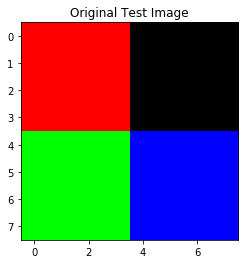

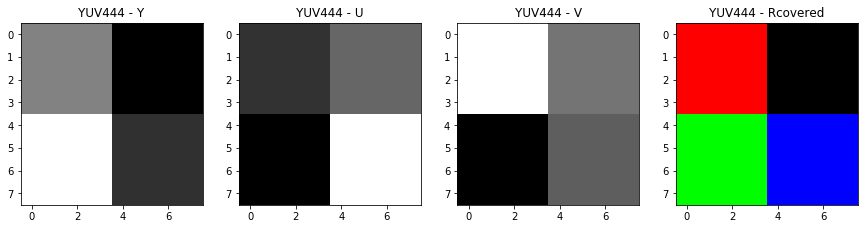

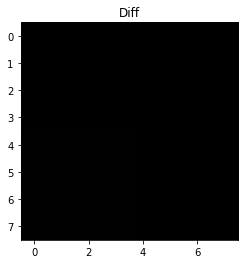

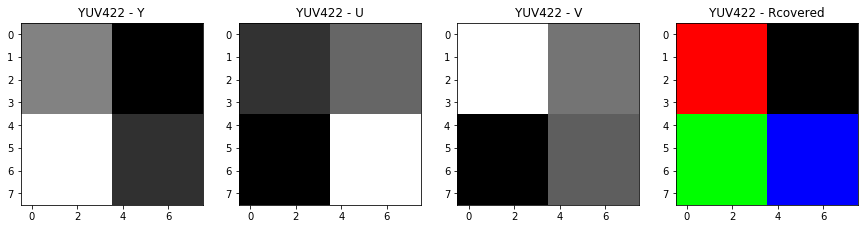

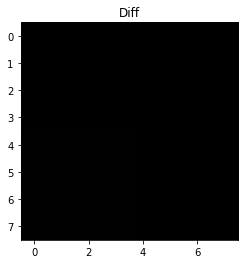

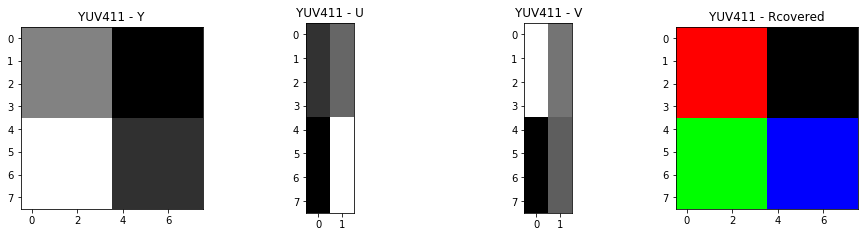

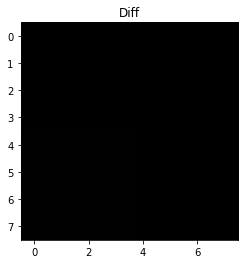

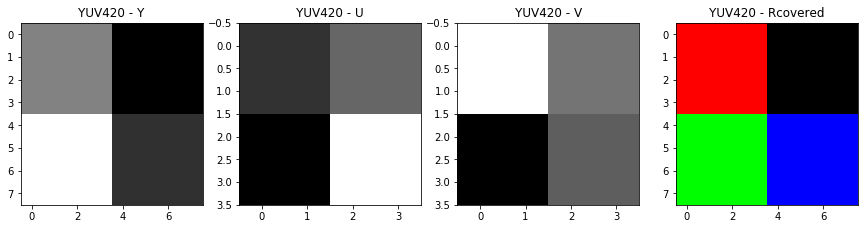

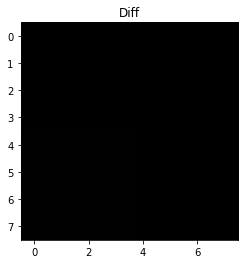

In [12]:
test_img = genTestImage()
(h, w, d) = test_img.shape
print("Original RGB image: %dx%d, %d bytes" % (w, h, w * h * 3))

# original
test_fig_rgb, test_plt_rgb = plt.subplots(1, 1)
test_plt_rgb.set_title('Original Test Image'); test_plt_rgb.imshow(test_img);

# YUV444
ysize444 = w * h
uvsize444 = w * h
test_444 = rgb8882yuv444(test_img)
test_444y = test_444[0:ysize444].reshape([h, w])
test_444u = test_444[ysize444:ysize444+uvsize444].reshape([h, w])
test_444v = test_444[ysize444+uvsize444:ysize444+2*uvsize444].reshape([h, w])
rgb_444 = yuv4442rgb888(test_444, w, h)
describeYUV(test_444y, test_444u, test_444v, "YUV444")

test_fig_444, (test_plt444y, test_plt444u, test_plt444v, test_plt444) = plt.subplots(1, 4, figsize=(15, 15))
test_plt444y.set_title('YUV444 - Y'); test_plt444y.imshow(test_444y, cmap='gray');
test_plt444u.set_title('YUV444 - U'); test_plt444u.imshow(test_444u, cmap='gray');
test_plt444v.set_title('YUV444 - V'); test_plt444v.imshow(test_444v, cmap='gray');
test_plt444.set_title('YUV444 - Rcovered'); test_plt444.imshow(rgb_444);

diff(rgb_444, test_img)

# YUV422
ysize422 = w * h
uvsize422 = (int)(w * h / 2)
test_422 = rgb8882yuv422(test_img)
test_422y = test_422[0:ysize422].reshape([h, w])
test_422u = test_422[ysize422:ysize422+uvsize422].reshape([h, int(w/2)])
test_422v = test_422[ysize422+uvsize422:ysize422+2*uvsize422].reshape([h, int(w/2)])
rgb_422 = yuv4222rgb888(test_422, w, h)
describeYUV(test_422y, test_422u, test_422v, "YUV422")

test_fig_422, (test_plt422y, test_plt422u, test_plt422v, test_plt422) = plt.subplots(1, 4, figsize=(15, 15))
test_plt422y.set_title('YUV422 - Y'); test_plt422y.imshow(test_444y, cmap='gray');
test_plt422u.set_title('YUV422 - U'); test_plt422u.imshow(test_444u, cmap='gray');
test_plt422v.set_title('YUV422 - V'); test_plt422v.imshow(test_444v, cmap='gray');
test_plt422.set_title('YUV422 - Rcovered'); test_plt422.imshow(rgb_422);

diff(rgb_422, test_img)

# YUV411
ysize411 = w * h
uvsize411 = (int)(w * h / 4)
test_411 = rgb8882yuv411(test_img)
test_411y = test_411[0:ysize411].reshape([h, w])
test_411u = test_411[ysize411:ysize411+uvsize411].reshape([h, int(w/4)])
test_411v = test_411[ysize411+uvsize411:ysize411+2*uvsize411].reshape([h, int(w/4)])
rgb_411 = yuv4112rgb888(test_411, w, h)
describeYUV(test_411y, test_411u, test_411v, "YUV411")

test_fig_411, (test_plt411y, test_plt411u, test_plt411v, test_plt411) = plt.subplots(1, 4, figsize=(15, 3.5))
test_plt411y.set_title('YUV411 - Y'); test_plt411y.imshow(test_411y, cmap='gray');
test_plt411u.set_title('YUV411 - U'); test_plt411u.imshow(test_411u, cmap='gray');
test_plt411v.set_title('YUV411 - V'); test_plt411v.imshow(test_411v, cmap='gray');
test_plt411.set_title('YUV411 - Rcovered'); test_plt411.imshow(rgb_411);

diff(rgb_411, test_img)

# YUV420
ysize420 = w * h
uvsize420 = (int)(w * h / 4)
test_420 = rgb8882yuv420(test_img)
test_420y = test_420[0:ysize420].reshape([h, w])
test_420u = test_420[ysize420:ysize420+uvsize420].reshape([int(h/2), int(w/2)])
test_420v = test_420[ysize420+uvsize420:ysize420+2*uvsize420].reshape([int(h/2), int(w/2)])
rgb_420 = yuv4202rgb888(test_420, w, h)
describeYUV(test_420y, test_420u, test_420v, "YUV420")

test_fig_420, (test_plt420y, test_plt420u, test_plt420v, test_plt420) = plt.subplots(1, 4, figsize=(15, 15))
test_plt420y.set_title('YUV420 - Y'); test_plt420y.imshow(test_420y, cmap='gray');
test_plt420u.set_title('YUV420 - U'); test_plt420u.imshow(test_420u, cmap='gray');
test_plt420v.set_title('YUV420 - V'); test_plt420v.imshow(test_420v, cmap='gray');
test_plt420.set_title('YUV420 - Rcovered'); test_plt420.imshow(rgb_420);

diff(rgb_420, test_img)

Original RGB image: 300x300, 270000 bytes
YUV444 image: Y (300x300), U (300x300), V (300x300), size 270000 bytes
YUV422 image: Y (300x300), U (150x300), V (150x300), size 180000 bytes
YUV411 image: Y (300x300), U (75x300), V (75x300), size 135000 bytes
YUV420 image: Y (300x300), U (150x150), V (150x150), size 135000 bytes


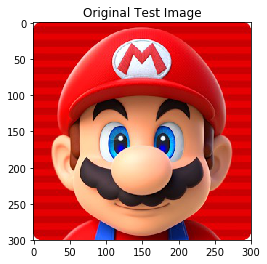

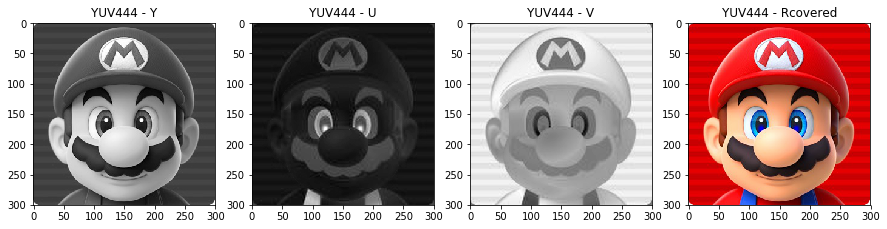

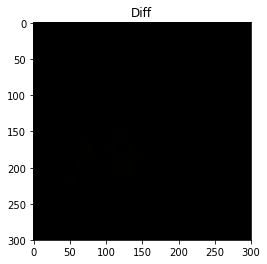

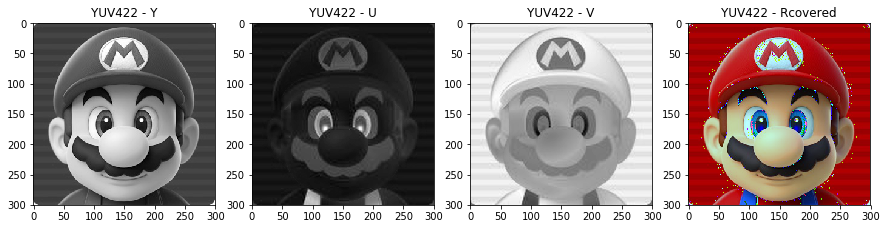

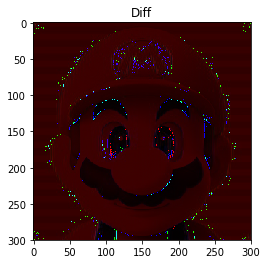

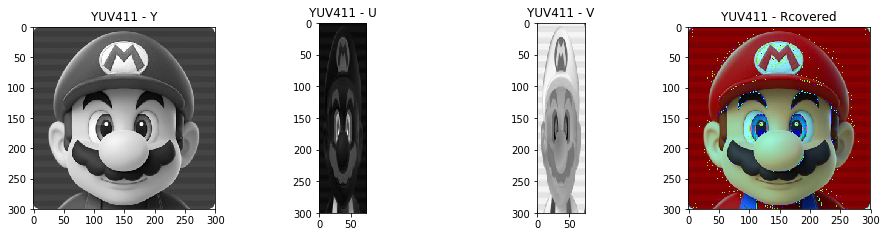

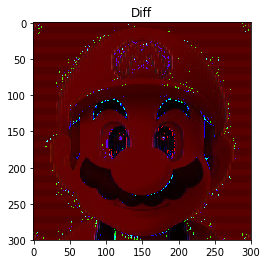

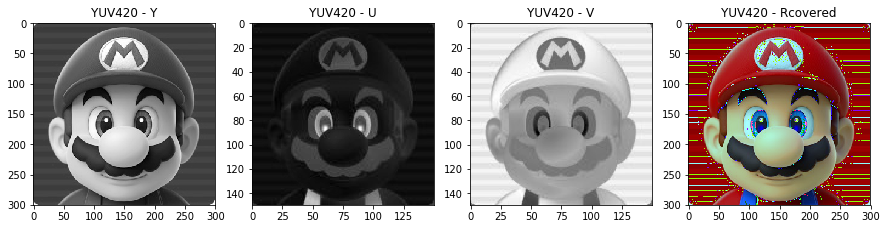

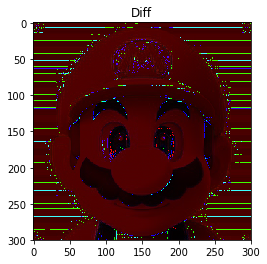

In [13]:
test_img = mpimg.imread('media/super_mario_head.jpg')
(h, w, d) = test_img.shape
print("Original RGB image: %dx%d, %d bytes" % (w, h, w * h * 3))

# original
test_fig_rgb, test_plt_rgb = plt.subplots(1, 1)
test_plt_rgb.set_title('Original Test Image'); test_plt_rgb.imshow(test_img);

# YUV444
ysize444 = w * h
uvsize444 = w * h
test_444 = rgb8882yuv444(test_img)
test_444y = test_444[0:ysize444].reshape([h, w])
test_444u = test_444[ysize444:ysize444+uvsize444].reshape([h, w])
test_444v = test_444[ysize444+uvsize444:ysize444+2*uvsize444].reshape([h, w])
rgb_444 = yuv4442rgb888(test_444, w, h)
describeYUV(test_444y, test_444u, test_444v, "YUV444")

test_fig_444, (test_plt444y, test_plt444u, test_plt444v, test_plt444) = plt.subplots(1, 4, figsize=(15, 15))
test_plt444y.set_title('YUV444 - Y'); test_plt444y.imshow(test_444y, cmap='gray');
test_plt444u.set_title('YUV444 - U'); test_plt444u.imshow(test_444u, cmap='gray');
test_plt444v.set_title('YUV444 - V'); test_plt444v.imshow(test_444v, cmap='gray');
test_plt444.set_title('YUV444 - Rcovered'); test_plt444.imshow(rgb_444);

diff(rgb_444, test_img)

# YUV422
ysize422 = w * h
uvsize422 = (int)(w * h / 2)
test_422 = rgb8882yuv422(test_img)
test_422y = test_422[0:ysize422].reshape([h, w])
test_422u = test_422[ysize422:ysize422+uvsize422].reshape([h, int(w/2)])
test_422v = test_422[ysize422+uvsize422:ysize422+2*uvsize422].reshape([h, int(w/2)])
rgb_422 = yuv4222rgb888(test_422, w, h)
describeYUV(test_422y, test_422u, test_422v, "YUV422")

test_fig_422, (test_plt422y, test_plt422u, test_plt422v, test_plt422) = plt.subplots(1, 4, figsize=(15, 15))
test_plt422y.set_title('YUV422 - Y'); test_plt422y.imshow(test_444y, cmap='gray');
test_plt422u.set_title('YUV422 - U'); test_plt422u.imshow(test_444u, cmap='gray');
test_plt422v.set_title('YUV422 - V'); test_plt422v.imshow(test_444v, cmap='gray');
test_plt422.set_title('YUV422 - Rcovered'); test_plt422.imshow(rgb_422);

diff(rgb_422, test_img)

# YUV411
ysize411 = w * h
uvsize411 = (int)(w * h / 4)
test_411 = rgb8882yuv411(test_img)
test_411y = test_411[0:ysize411].reshape([h, w])
test_411u = test_411[ysize411:ysize411+uvsize411].reshape([h, int(w/4)])
test_411v = test_411[ysize411+uvsize411:ysize411+2*uvsize411].reshape([h, int(w/4)])
rgb_411 = yuv4112rgb888(test_411, w, h)
describeYUV(test_411y, test_411u, test_411v, "YUV411")

test_fig_411, (test_plt411y, test_plt411u, test_plt411v, test_plt411) = plt.subplots(1, 4, figsize=(15, 3.5))
test_plt411y.set_title('YUV411 - Y'); test_plt411y.imshow(test_411y, cmap='gray');
test_plt411u.set_title('YUV411 - U'); test_plt411u.imshow(test_411u, cmap='gray');
test_plt411v.set_title('YUV411 - V'); test_plt411v.imshow(test_411v, cmap='gray');
test_plt411.set_title('YUV411 - Rcovered'); test_plt411.imshow(rgb_411);

diff(rgb_411, test_img)

# YUV420
ysize420 = w * h
uvsize420 = (int)(w * h / 4)
test_420 = rgb8882yuv420(test_img)
test_420y = test_420[0:ysize420].reshape([h, w])
test_420u = test_420[ysize420:ysize420+uvsize420].reshape([int(h/2), int(w/2)])
test_420v = test_420[ysize420+uvsize420:ysize420+2*uvsize420].reshape([int(h/2), int(w/2)])
rgb_420 = yuv4202rgb888(test_420, w, h)
describeYUV(test_420y, test_420u, test_420v, "YUV420")

test_fig_420, (test_plt420y, test_plt420u, test_plt420v, test_plt420) = plt.subplots(1, 4, figsize=(15, 15))
test_plt420y.set_title('YUV420 - Y'); test_plt420y.imshow(test_420y, cmap='gray');
test_plt420u.set_title('YUV420 - U'); test_plt420u.imshow(test_420u, cmap='gray');
test_plt420v.set_title('YUV420 - V'); test_plt420v.imshow(test_420v, cmap='gray');
test_plt420.set_title('YUV420 - Rcovered'); test_plt420.imshow(rgb_420);

diff(rgb_420, test_img)